In [1]:
import numpy as np
import pandas as pd

import sys
sys.path.append('models/')
sys.path.append('Datasets/')
import models
import datasets
import audio_utils

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import librosa
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import torch.nn as nn
import torch.nn.functional as F

def init_layer(layer, nonlinearity='leaky_relu'):
    """Initialize a Linear or Convolutional layer. """
    nn.init.kaiming_uniform_(layer.weight, nonlinearity=nonlinearity)

    if hasattr(layer, 'bias'):
        if layer.bias is not None:
            layer.bias.data.fill_(0.)
    
    
def init_bn(bn):
    """Initialize a Batchnorm layer. """
    
    bn.bias.data.fill_(0.)
    bn.running_mean.data.fill_(0.)
    bn.weight.data.fill_(1.)
    bn.running_var.data.fill_(1.)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        
        super(ConvBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                              out_channels=out_channels,
                              kernel_size=(3, 3), stride=(1, 1),
                              padding=(1, 1), bias=False)
                              
        self.conv2 = nn.Conv2d(in_channels=out_channels, 
                              out_channels=out_channels,
                              kernel_size=(3, 3), stride=(1, 1),
                              padding=(1, 1), bias=False)
                              
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.init_weights()
        
    def init_weights(self):
        
        init_layer(self.conv1)
        init_layer(self.conv2)
        init_bn(self.bn1)
        init_bn(self.bn2)
        
    def forward(self, input, pool_size=(2, 2), pool_type='avg'):
        
        x = input
        x = F.relu_(self.bn1(self.conv1(x)))
        x = F.relu_(self.bn2(self.conv2(x)))
        if pool_type == 'max':
            x = F.max_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg':
            x = F.avg_pool2d(x, kernel_size=pool_size)
        else:
            raise Exception('Incorrect argument!')
        
        return x
    
    
class Cnn_9layers_AvgPooling(nn.Module):
    
    def __init__(self, classes_num, activation):
        super(Cnn_9layers_AvgPooling, self).__init__()

        self.activation = activation

        self.conv_block1 = ConvBlock(in_channels=1, out_channels=64)
        self.conv_block2 = ConvBlock(in_channels=64, out_channels=128)
        self.conv_block3 = ConvBlock(in_channels=128, out_channels=256)
        self.conv_block4 = ConvBlock(in_channels=256, out_channels=512)

        self.fc = nn.Linear(512, classes_num, bias=True)

        self.init_weights()

    def init_weights(self):

        init_layer(self.fc)

    def forward(self, input):
        '''
        Input: (batch_size, times_steps, freq_bins)'''
        
        x = input[:, None, :, :]
        '''(batch_size, 1, times_steps, freq_bins)'''
        
        x = self.conv_block1(x, pool_size=(2, 2), pool_type='avg')
        x = self.conv_block2(x, pool_size=(2, 2), pool_type='avg')
        x = self.conv_block3(x, pool_size=(2, 2), pool_type='avg')
        x = self.conv_block4(x, pool_size=(1, 1), pool_type='avg')
        '''(batch_size, feature_maps, time_steps, freq_bins)'''
        
        x = torch.mean(x, dim=3)        # (batch_size, feature_maps, time_stpes)
        (x, _) = torch.max(x, dim=2)    # (batch_size, feature_maps)
        x = self.fc(x)
        
        if self.activation == 'logsoftmax':
            output = F.log_softmax(x, dim=-1)
            
        elif self.activation == 'sigmoid':
            output = torch.sigmoid(x)
        
        return output

In [3]:
model = Cnn_9layers_AvgPooling(classes_num=10, activation='logsoftmax')

In [4]:
SAMPLE_RATE = 32000
WINDOW_SIZE = 1024
HOP_SIZE = 500
MEL_BINS = 64
FMIN = 50
FMAX = 14000

def get_logMel(audio):
    log_mel = audio_utils.get_log_melSpectrogram(
        audio, sample_rate=SAMPLE_RATE, n_mels=MEL_BINS, n_fft=WINDOW_SIZE, hop_len=HOP_SIZE
    )
    return log_mel.squeeze()
'''
log_mel = audio_utils.get_log_melSpectrogram(
    audio, sample_rate=SAMPLE_RATE, n_mels=MEL_BINS, n_fft=WINDOW_SIZE, hop_len=HOP_SIZE
)

librosa.display.specshow(log_mel.squeeze().numpy(), sr=SAMPLE_RATE, x_axis='time', y_axis='mel',
                         hop_length=HOP_SIZE, n_fft=WINDOW_SIZE, fmin=FMIN, fmax=FMAX)'''

"\nlog_mel = audio_utils.get_log_melSpectrogram(\n    audio, sample_rate=SAMPLE_RATE, n_mels=MEL_BINS, n_fft=WINDOW_SIZE, hop_len=HOP_SIZE\n)\n\nlibrosa.display.specshow(log_mel.squeeze().numpy(), sr=SAMPLE_RATE, x_axis='time', y_axis='mel',\n                         hop_length=HOP_SIZE, n_fft=WINDOW_SIZE, fmin=FMIN, fmax=FMAX)"

In [5]:
aud_dir = datasets.SCAPPER_AUD_DIR + 'train/'
scapper_dataset = datasets.scraperDataset(datasets.SCAPPER_TRAIN_CSV, aud_dir, only_scene=True, transforms=get_logMel)
scapper_train_dataset = DataLoader(scapper_dataset, batch_size=32, shuffle=True)

In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [7]:
epochs = 10

for epoch in range(epochs):
    model = models.train(model, 'cuda', scapper_train_dataset, loss_fn, optimizer, epoch)

Train Epoch: 0 [0/3000 (0%)]	Loss: 3.292786
Train Epoch: 1 [0/3000 (0%)]	Loss: 1.048158
Train Epoch: 2 [0/3000 (0%)]	Loss: 0.728987
Train Epoch: 3 [0/3000 (0%)]	Loss: 0.187935
Train Epoch: 4 [0/3000 (0%)]	Loss: 0.145081
Train Epoch: 5 [0/3000 (0%)]	Loss: 0.264275
Train Epoch: 6 [0/3000 (0%)]	Loss: 0.175713
Train Epoch: 7 [0/3000 (0%)]	Loss: 0.054300
Train Epoch: 8 [0/3000 (0%)]	Loss: 0.031278
Train Epoch: 9 [0/3000 (0%)]	Loss: 0.108043


In [9]:
torch.save(model.state_dict(), 'ASC_scapper_Cnn9_64mel_10epochs.pt') 

In [12]:
scapper_test_csv = datasets.SCAPPER_TEST_CSV
scapper_test_df = pd.read_csv(scapper_test_csv)

scapper_test_df.head(2)

,audio_fileNames,label_fileNames,acoustic_scene_label,events_label_list
0,bus10_0.wav,bus10_0.jams,bus,"['cough', 'phone', 'keys', 'phone', 'cough', '..."
1,bus10_1.wav,bus10_1.jams,bus,"['keys', 'clearthroat', 'laughter', 'keys', 'p..."


In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import os
preds = []

for i, row in scapper_test_df.iterrows():
    audio_file = os.path.join(datasets.SCAPPER_AUD_DIR + 'test/', row['audio_fileNames'])
    audio = audio_utils.load_audio_from_file(audio_file, sample_rate=SAMPLE_RATE)
    log_mel = get_logMel(audio)

    model.eval()
    with torch.no_grad():
        output = model(log_mel.unsqueeze(0).to('cuda'))

    pred = torch.argmax(torch.sigmoid((output.cpu())))
    preds.append(pred)

In [17]:
scapper_scenes = scapper_test_df['acoustic_scene_label'].unique()

for i in range(len(preds)):
    preds[i] = scapper_scenes[preds[i]]


['bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',
 'bus',


In [21]:
print(classification_report(scapper_test_df['acoustic_scene_label'], preds))

               precision    recall  f1-score   support

          bus       1.00      1.00      1.00       300
   busystreet       0.99      1.00      1.00       300
       office       0.99      0.99      0.99       300
openairmarket       0.98      1.00      0.99       300
         park       0.97      0.97      0.97       300
  quietstreet       1.00      0.98      0.99       300
   restaurant       0.98      1.00      0.99       300
  supermarket       1.00      0.97      0.99       300
         tube       0.85      1.00      0.92       300
  tubestation       1.00      0.83      0.91       300

     accuracy                           0.97      3000
    macro avg       0.98      0.97      0.97      3000
 weighted avg       0.98      0.97      0.97      3000



<Axes: >

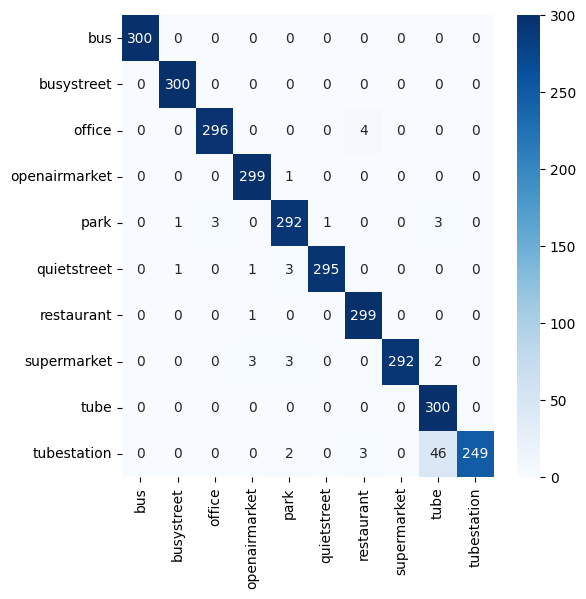

In [20]:
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_matrix(scapper_test_df['acoustic_scene_label'], preds), annot=True, fmt='d', cmap='Blues', xticklabels=scapper_scenes, yticklabels=scapper_scenes)

In [24]:
scapper_test_df['preds'] = preds
scapper_test_df.to_csv('predictions/ASC_scapper_Cnn9_64mel_10epochs.csv', index=False)